In [24]:
import numpy as np
from __future__ import print_function
import torch
import rasterio
import gdal
import geopandas
import pandas as pd
from src import geotools as gt
import matplotlib.pyplot as plt
from rasterio.plot import show as rshow
from src import ptmodel as pt
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde
np.random.seed(1234)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def write_sample(outname, arr, proj, transform):
        xsize = arr.shape[2]
        ysize = arr.shape[1]
        bands = 1
        driver = gdal.GetDriverByName('GTiff')
        srs = osr.SpatialReference()
        srs.ImportFromWkt(proj)
        out = driver.Create(outname, xsize, ysize, bands, gdal.GDT_Float32)
        out.SetProjection(srs.ExportToWkt())
        out.SetGeoTransform(transform)
        for band in range(1, bands+1):
            exportband = arr[band-1, :, :]
            out.GetRasterBand(band).WriteArray(exportband)
        del out

BoundingBox(left=-73352.6215, bottom=192402.3655, right=85821.3785, top=414306.3655)


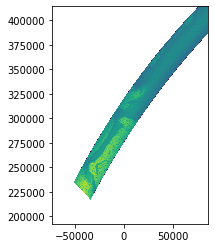

BoundingBox(left=-8102.6215, bottom=292014.3655, right=6639.3785, top=305154.3655)


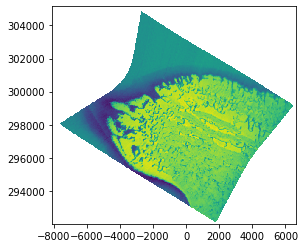

In [41]:
def grab_raster_values(filename, points=False,
                       neighbs=False, plotit=False):
    ds = gdal.Open(filename)
    transform = ds.GetGeoTransform()
    xOrigin = transform[0]
    yOrigin = transform[3]
    pixelWidth = transform[1]
    pixelHeight = transform[5]
    outvals = []
    rastds = rasterio.open(filename)
    print(rastds.bounds)
    data = rastds.read()
    if plotit:
        rshow(rastds)
    if not points:
        #If coordinates not given, pull example
        points=[(-4320,299085)]
    outvals=[]
    for pttup in points:
        x,y= pttup
        row,col=rastds.index(x,y)
        if neighbs:
            extract = data[:, (row - neighbs - 1): (row + neighbs + 2),
                                 (col - neighbs - 1): (col + neighbs + 2)]
#             extract=np.swapaxes(np.swapaxes(extract,0,-1),0,1)
        else:
            extract = data[:, row, col]
        outvals.append(extract)
        
    return(outvals)
ctxvals=grab_raster_values('data/P12_005773_0849_XN_84S045W_final',neighbs=30,plotit=True)
crismvals=grab_raster_values('data/8517_param_icer1_2.tif',neighbs=30,plotit=True)


In [34]:
def sample_im_pixels(number, geoimagenm):
    rastds = rasterio.open(geoimagenm)
    min_x, min_y, max_x, max_y = rastds.bounds
    outlist=[]
    rastdata=rastds.read()
    i=0
    while i < number:
        x,y=np.random.uniform(min_x, max_x), \
            np.random.uniform(min_y, max_y)
        point = (x,y)
        row,col=rastds.index(x,y)
        if rastdata[0,row,col] > 60000:
            continue
        else:
            outlist.append(point)
        i=len(outlist)
    return(outlist)
pointlist=sample_im_pixels(10000,'data/8517_param_icer1_2.tif')

In [35]:
ddrsamples=grab_raster_values('data/frt00008517_07_de163l_ddr1_p.img',points=pointlist,neighbs=False,plotit=False)
crismsamples=grab_raster_values('data/8517_param_icer1_2.tif',points=pointlist,neighbs=False,plotit=False)
ctxsamples=grab_raster_values('data/P12_005773_0849_XN_84S045W_final',points=pointlist,neighbs=2,plotit=False)
datadict={'DDR':ddrsamples,'CTX':ctxsamples,'CRISM':crismsamples,'COORDS':pointlist}

10000 10000 10000


Text(0.5, 1.0, 'Brightness vs Band Parameter')

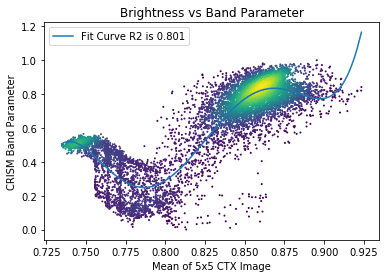

In [38]:
print(len(ddrsamples),len(crismsamples),len(ctxsamples))
iceds=pt.ICEsDataset(datadict)
iceds.normalize()
meanlist,ylist=[],[]
for i in range(len(iceds)):
    sample = iceds[i]
    sampmean=np.mean(sample['X'])
    meanlist.append(sampmean)
    ylist.append(sample['Y'][0])
xy = np.vstack([meanlist,ylist])
z = gaussian_kde(xy)(xy)    
plt.scatter(meanlist,ylist,c=z,s=1)
sortinds=np.argsort(meanlist)
fitcoeffs=np.polyfit(meanlist,ylist,5)
fitcurve=np.polyval(fitcoeffs,meanlist)
r2=r2_score(ylist,fitcurve)
plt.plot(np.array(meanlist)[sortinds],fitcurve[sortinds],label='Fit Curve R2 is '+ str(np.around(r2,3)))
plt.legend()
plt.xlabel('Mean of 5x5 CTX Image')
plt.ylabel('CRISM Band Parameter')
plt.title('Brightness vs Band Parameter')

AttributeError: 'dict' object has no attribute 'shape'

In [107]:
def gen_split(dataset,valper=.15,batchsize=50):
    train_dataset = dataset
    valinds=[]

    valinds=np.random.choice(np.arange(0,len(iceds)),int(len(iceds)*.15),replace=False)
    print(len(valinds))

    traininds=np.array([x for x in np.arange(0,len(iceds)) \
               if x not in valinds])
    print(len(traininds))
    subset_indices_train = traininds
    subset_indices_valid = valinds


    np.random.shuffle(subset_indices_train)
    np.random.shuffle(subset_indices_valid)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batchsize,
        sampler=SubsetRandomSampler(subset_indices_train)
    )
    val_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=len(valinds),
        sampler=SubsetRandomSampler(subset_indices_valid)
    )
    return(train_loader,val_loader)

15000
85000


In [108]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from sklearn import manifold
from matplotlib import offsetbox

Net(
  (conv1): Conv2d(1, 9, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(9, 16, kernel_size=(2, 2), stride=(1, 1))
  (bn): BatchNorm2d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=144, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=1, bias=True)
)
25421 Total Model Parameters.
Train Epoch: 1 [0/85000 (0%)]	Loss: 0.287645
Train Epoch: 1 [25000/85000 (29%)]	Loss: 0.008247
Train Epoch: 1 [50000/85000 (59%)]	Loss: 0.006353
Train Epoch: 1 [75000/85000 (88%)]	Loss: 0.006556

Test set: Average loss: 0.0215, Accuracy: 0/15000 (0%)

Train Epoch: 2 [0/85000 (0%)]	Loss: 0.012108
Train Epoch: 2 [25000/85000 (29%)]	Loss: 0.009506
Train Epoch: 2 [50000/85000 (59%)]	Loss: 0.010213
Train Epoch: 2 [75000/85000 (88%)]	Loss: 0.007023

Test set: Average loss: 0.0093, Accuracy: 0/15000 (0%)

Train Epoch: 3 [0/85000 (0%)]	Loss: 0.008893
Train Epoch: 3 [25000/8500

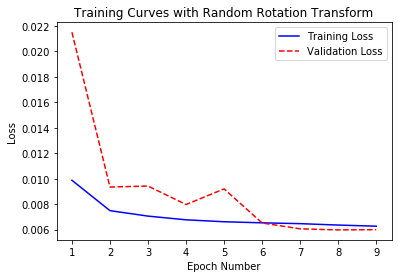

In [109]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1234)
device = torch.device("cuda" if use_cuda else "cpu")
model = pt.Net().to(device)
print(model)

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(str(params) +' Total Model Parameters.')

optimizer = optim.Adadelta(model.parameters(), lr=1 )

# Set your learning rate scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=.7)

trloss_list=[]
tstloss_list=[]
for epoch in range(1, 10):
    trloss=pt.train_epoch(model, device, train_loader, optimizer, epoch,retloss=True)
    tstloss=pt.test(model, device, val_loader,retloss=True)
    if trloss:
        trloss_list.append(trloss)
        tstloss_list.append(tstloss)
    scheduler.step()    # learning rate scheduler
plt.plot(np.arange(1,10), trloss_list, label='Training Loss', linestyle='-', color='blue')
plt.plot(np.arange(1,10), tstloss_list, label='Validation Loss', linestyle='--', color='red')
plt.legend()
plt.title('Training Curves')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.show()

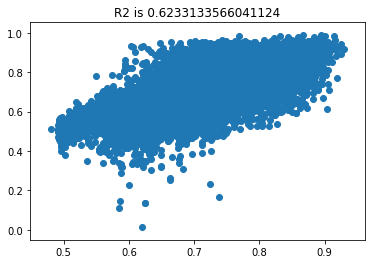

In [110]:
model.eval()
with torch.no_grad():   # For the inference step, gradient is not computed
        for batch_idx, data in enumerate(val_loader):
            data, target = data['X'].to(
              device, dtype=torch.float), data['Y'].to(device, dtype=torch.float)
            output = model(data)
            pred=output.cpu().numpy()[:,0]
            targnp=target.cpu().numpy()[:,0]
            plt.scatter(pred,targnp)
            plt.title('R2 is '+ str(r2_score(pred,targnp)))